100%|██████████| 170M/170M [00:11<00:00, 14.7MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Epoch [1/10], Loss: 1.7581, Accuracy: 34.67%
Epoch [2/10], Loss: 1.3948, Accuracy: 49.31%
Epoch [3/10], Loss: 1.2189, Accuracy: 56.40%
Epoch [4/10], Loss: 1.1033, Accuracy: 61.07%
Epoch [5/10], Loss: 1.0414, Accuracy: 63.82%
Epoch [6/10], Loss: 0.9943, Accuracy: 65.52%
Epoch [7/10], Loss: 0.9481, Accuracy: 67.33%
Epoch [8/10], Loss: 0.9250, Accuracy: 68.06%
Epoch [9/10], Loss: 0.9021, Accuracy: 69.17%
Epoch [10/10], Loss: 0.8803, Accuracy: 69.85%
Test Accuracy: 74.62%


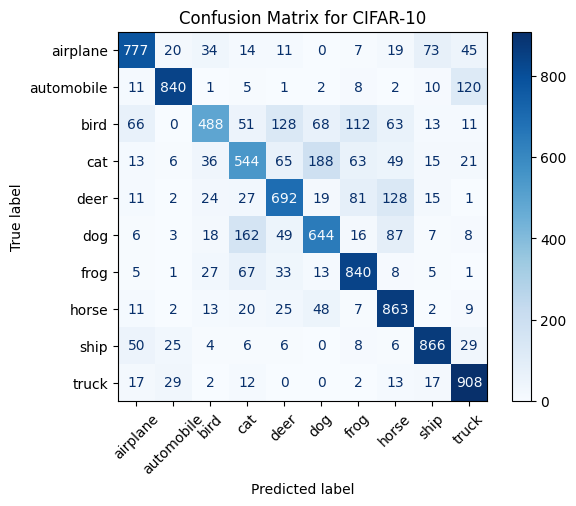

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Device Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# CIFAR-10 Dataset Loading and Preprocessing
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

# Enhanced CNN Model
class EnhancedCNN(nn.Module):
    def __init__(self):
        super(EnhancedCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 8 * 8)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

# LeNet-5 Model (Adapted for CIFAR-10)
class LeNet5(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1)
        self.fc1 = nn.Linear(16 * 8 * 8, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = x.view(-1, 16 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Select Model
model = EnhancedCNN().to(device)  # Switch to LeNet5() if required

# Define Loss, Optimizer, and Scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# Training Loop
epochs = 10
train_losses = []
test_accuracies = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_acc = 100. * correct / total
    train_losses.append(running_loss / len(train_loader))
    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {running_loss / len(train_loader):.4f}, Accuracy: {train_acc:.2f}%")

    # Step the scheduler
    scheduler.step()

# Testing Loop
model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_acc = 100. * correct / total
test_accuracies.append(test_acc)
print(f"Test Accuracy: {test_acc:.2f}%")

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix for CIFAR-10")
plt.show()




In [2]:
def compute_classification_report(actual_labels, predicted_labels, num_classes=10):
    # Initialize confusion matrix
    confusion_matrix = [[0 for _ in range(num_classes)] for _ in range(num_classes)]

    # Populate confusion matrix
    for i in range(len(actual_labels)):
        true_label = int(actual_labels[i])
        pred_label = int(predicted_labels[i])
        confusion_matrix[true_label][pred_label] += 1

    # Initialize metrics
    precision = [0] * num_classes
    recall = [0] * num_classes
    f1_score = [0] * num_classes

    # Calculate metrics for each class
    for cls in range(num_classes):
        tp = confusion_matrix[cls][cls]
        fp = sum(confusion_matrix[row][cls] for row in range(num_classes)) - tp
        fn = sum(confusion_matrix[cls]) - tp

        # Precision: TP / (TP + FP)
        precision[cls] = tp / (tp + fp) if (tp + fp) > 0 else 0.0

        # Recall: TP / (TP + FN)
        recall[cls] = tp / (tp + fn) if (tp + fn) > 0 else 0.0

        # F1-Score: 2 * (Precision * Recall) / (Precision + Recall)
        f1_score[cls] = (
            2 * precision[cls] * recall[cls] / (precision[cls] + recall[cls])
            if (precision[cls] + recall[cls]) > 0
            else 0.0
        )

    # Calculate macro-averages
    macro_precision = sum(precision) / num_classes
    macro_recall = sum(recall) / num_classes
    macro_f1 = sum(f1_score) / num_classes

    # Display the classification report
    print("Class\tPrecision\tRecall\t\tF1-Score")
    for cls in range(num_classes):
        print(f"{cls}\t{precision[cls]:.2f}\t\t{recall[cls]:.2f}\t\t{f1_score[cls]:.2f}")

    print("\nMacro-Average Metrics:")
    print(f"Precision: {macro_precision:.2f}")
    print(f"Recall: {macro_recall:.2f}")
    print(f"F1-Score: {macro_f1:.2f}")

    return precision, recall, f1_score, macro_precision, macro_recall, macro_f1


# Example usage
true_labels = [0, 1, 2, 1, 0, 2, 1, 2, 0, 2]  # Replace with your actual labels
predictions = [0, 1, 1, 1, 0, 2, 0, 2, 2, 2]  # Replace with your predicted labels

precision, recall, f1_score, macro_precision, macro_recall, macro_f1 = compute_classification_report(
    true_labels, predictions, num_classes=10
)


Class	Precision	Recall		F1-Score
0	0.67		0.67		0.67
1	0.67		0.67		0.67
2	0.75		0.75		0.75
3	0.00		0.00		0.00
4	0.00		0.00		0.00
5	0.00		0.00		0.00
6	0.00		0.00		0.00
7	0.00		0.00		0.00
8	0.00		0.00		0.00
9	0.00		0.00		0.00

Macro-Average Metrics:
Precision: 0.21
Recall: 0.21
F1-Score: 0.21
